# Introduction





# To BLT or to still BPE - that is here the question

Let's dig into Machine Learning for Log Analysis, specifically on 

* *tokenization* with **Byte-Pair Encoding** (BPE) or **Byte Latent Transformation** (BLT)

We will compare the work with *Linformer* (also Meta research) as a model to create compareable log vector representations (same parameters).

[Linformer](https://transparency.meta.com/en-gb/enforcement/detecting-violations/investing-in-technology/) has originally been developed to detect *hate speech*, which includes symbols or other obfuscated text that could be used to identify or target specific groups of people. It is a state-of-the-art model that uses *Transformer* and *Attention* mechanisms.

We evaluate the embeddings based on common model metrics. Linformer has the advantage that it scales linearly with O(n) with longer sequences -- for both memory and computation time.

In case of logs this is key given the potencial volume and throughput. The expected length of Byte-Pair-Encoding (BPE) vs. Byte-Latent-Transformation (BLT) tokens is 8-16 times longer. Therefore, a Deep Learning model with anAttention mechanism with linear complexity is ideal for log analysis.

But BLT promises good runtime and high-inference now as well. Time to get serious...

**Note: this is research level code. Couple of bugs here and there. Read with caution.**

### Load the config

The `config.json` is in the .gitignore file. 

The structure is as follows:
```json
{
    "huggingface_token": "hf...",
    "data_path": "~/source/datasets/log2ml/lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors_clean.parquet",
    "blt_dir": "~/source/projects/infosec_ml_rnd/bpe_vs_blt_log_vec/blt"
}
```

You probably need to change the paths to your own.

In [3]:
import importlib
import blt_wrapper.blt_wrapper  # Import the full module first

# Reload the module to refresh it after code changes
importlib.reload(blt_wrapper.blt_wrapper)

# Re-import the function (Python has persitent imports anyway, especially in Jupyter)
from blt_wrapper.blt_wrapper import load_config
hf_token, blt_dir = load_config("config.json")

## Hands on Byte Level Transformers

### BLT = Byte Level Transformer

The following parts work with the new research code from Meta. It's verbose code, but that's in the nature of ML if you look behind the scenes.



You need your Huggingface token, and you need it now.

In [6]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import dl_blt_tokenizer
from blt_wrapper.blt_wrapper import load_blt_lib


# pass the loaded HF token
dl_blt_tokenizer(hf_token)
load_blt_lib(blt_dir)

Successfully downloaded tokenizer to: tokenizers\tokenizer.model
Loading from blt_dir: C:\Users\mariu\source\projects\infosec_ml_rnd\bpe_vs_blt_log_vec\blt
BLT imports successful!


In [7]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_tokenizers

init_and_test_tokenizers()


Tokenizers initialized successfully!

Test results:
Original text: Hello, this is a test.
BPE tokens: [1, 15043, 29892, 445, 338, 263, 1243, 29889, 2]
BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 50, 2]
Sentence length:    22
BPE tokens created: 9
BLT tokens created: 31


Observation: BLT tokens here (this is the first step) are longer.

### What about the Patches?

There are

- Entropy based patches
- BPE based patches
- Space

In [8]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_byte_patcher

init_and_test_byte_patcher()



Byte Patcher initialized successfully!

Byte Patcher test results:
Original data length: 71 bytes
Batch shape: torch.Size([1, 71])
Number of patches: 9
Patch 0: Length=8, Data=b'Hello Wo'
Patch 1: Length=8, Data=b'rld! Thi'
Patch 2: Length=8, Data=b's is som'
Patch 3: Length=8, Data=b'e test b'
Patch 4: Length=8, Data=b'inary da'
Patch 5: Length=8, Data=b'ta with '
Patch 6: Length=8, Data=b'varying '
Patch 7: Length=8, Data=b'entropy '
Patch 8: Length=7, Data=b'levels.'


(<bytelatent.data.patcher.Patcher at 0x17b5b6a1390>,
 tensor([[8, 8, 8, 8, 8, 8, 8, 8, 7]]))

In [10]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_bpe_patcher

init_and_test_bpe_patcher()



BPE Patcher initialized successfully!

BPE Patcher test results:
Original text: Hello, this is a test for BPE patching!
BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 36, 106, 115, 118, 3, 36, 70, 3, 84, 73, 3, 36, 116, 101, 120, 103, 108, 3, 109, 114, 107, 3, 37, 2]
Patch lengths: [[1, 1, 6, 2, 6, 4, 3, 6, 5, 3, 3, 7, 4, 2]]
Patch 0: Length=1, Tokens=[1]
Patch 1: Length=1, Tokens=[3]
Patch 2: Length=6, Tokens=[76, 105, 112, 112, 115, 3]
Patch 3: Length=2, Tokens=[48, 3]
Patch 4: Length=6, Tokens=[36, 120, 108, 109, 119, 3]
Patch 5: Length=4, Tokens=[36, 109, 119, 3]
Patch 6: Length=3, Tokens=[36, 101, 3]
Patch 7: Length=6, Tokens=[36, 120, 105, 119, 120, 3]
Patch 8: Length=5, Tokens=[36, 106, 115, 118, 3]
Patch 9: Length=3, Tokens=[36, 70, 3]
Patch 10: Length=3, Tokens=[84, 73, 3]
Patch 11: Length=7, Tokens=[36, 116, 101, 120, 103, 108, 3]
Patch 12: Length=4, Tokens=[109, 114, 107, 3]
Patch 13: L

(<bytelatent.data.patcher.Patcher at 0x17b5b5b2620>,
 tensor([[1, 1, 6, 2, 6, 4, 3, 6, 5, 3, 3, 7, 4, 2]]),
 [1,
  3,
  76,
  105,
  112,
  112,
  115,
  3,
  48,
  3,
  36,
  120,
  108,
  109,
  119,
  3,
  36,
  109,
  119,
  3,
  36,
  101,
  3,
  36,
  120,
  105,
  119,
  120,
  3,
  36,
  106,
  115,
  118,
  3,
  36,
  70,
  3,
  84,
  73,
  3,
  36,
  116,
  101,
  120,
  103,
  108,
  3,
  109,
  114,
  107,
  3,
  37,
  2])

There are differences. Longer sequences (first step), which has an implication of Attention for the models.

## From BLT Patches to BLT Transformer Embeddings

In [12]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import create_blt_model, get_model_hidden_states, make_blt_embeddings

# Create model and test embeddings
tokenizer_path = Path("tokenizers/tokenizer.model")
model = create_blt_model()
test_text = "Hello, this is a test."

hidden_states = get_model_hidden_states(test_text, model, tokenizer_path, verbose=True)
embeddings = make_blt_embeddings()

Initializing model with:
- Model dimension: 1024
- Number of heads: 16
Creating model...
Model initialized successfully on cuda

=== Analyzing Model Hidden States ===
Input text: 'Hello, this is a test.'

Base output shape: torch.Size([1, 31, 1024])
Final output shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Hidden dimension: 1024
• Device: cuda:0
• Dtype: torch.float16

Statistics:
• Mean: 0.003
• Std: 0.330
• Min: -1.255
• Max: 1.340

Value Distribution:
• 0th percentile: -1.255
• 25th percentile: -0.222
• 50th percentile: 0.003
• 75th percentile: 0.228
• 100th percentile: 1.340

=== BLT Embedding Analysis ===

Input Text: "Hello, this is a test."

=== TOKEN Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Embedding dimension: 1024
• Parameters: 31,744
• Share of total: 33.33%

Statistics:
• Mean: -0.010
• Std: 0.576
• Min: -2.230
• Max: 2.215

=== POSITION Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1

In [15]:
for emb in embeddings:
    print(emb)

token
position
final


In [17]:
print(hidden_states.shape)

torch.Size([1, 31, 1024])


In [38]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import get_text_embedding

# this is the function we are going to use to create a lot of embeddings
# this reuses variables from the previous cell
blt_embedding = get_text_embedding(test_text, model, tokenizer_path)

In [39]:
print(test_text)
print(blt_embedding.shape)
print(blt_embedding)

Hello, this is a test.
torch.Size([1024])
tensor([-0.2285, -0.0190,  0.0225,  ...,  0.2822, -0.0433,  0.1328],
       device='cuda:0', dtype=torch.float16)


## Linformer Embeddings with Byte-Pair-Encoding

In [40]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import get_linformer_embedding

# this is the function we are going to use to create a lot of embeddings
# this reuses variables from the previous cell
linformer_embedding = get_linformer_embedding(test_text, tokenizer_path)

In [41]:
print(test_text)
print(linformer_embedding.shape)
print(linformer_embedding)

Hello, this is a test.
torch.Size([1024])
tensor([ 0.2234, -0.2493, -0.0166,  ..., -0.3284,  0.3979,  0.2284],
       device='cuda:0', dtype=torch.float16)


## Cosine Similarity

In [45]:
import torch
# Compute cosine similarity
cos = torch.nn.CosineSimilarity(dim=0)
similarity = cos(blt_embedding, linformer_embedding)
print(f"\nCosine Similarity between embeddings: {similarity.item():.4f}")


Cosine Similarity between embeddings: -0.0066


## BLT and BPE on Sysmon telemetry

*Sysmon telemetry* here refers to observed data, which has been generated in a lab. The dataset contains no malicious data, no personal information, and no sensitive data. It's from a lab environment, which I hosted for my thesis. No employer data, no client data, no nothing :) 

In [48]:
import importlib
import data_manager.data_manager

# Same pattern of refreshing
importlib.reload(data_manager.data_manager)
from data_manager.data_manager import load_filtered_messages

messages_df = load_filtered_messages()
messages_df

,filtered_message
0,Network connection detected: \nRuleName: -\nPr...
1,Network connection detected: \nRuleName: -\nPr...
2,Process accessed: \nRuleName: -\nSourceProcess...
3,Process accessed: \nRuleName: -\nSourceProcess...
4,Process accessed: \nRuleName: -\nSourceProcess...
...,...
13450,Process accessed: \nRuleName: -\nSourceProcess...
13451,Process accessed: \nRuleName: -\nSourceProcess...
13452,Process accessed: \nRuleName: -\nSourceProcess...
13453,Process accessed: \nRuleName: -\nSourceProcess...


The creation of Embeddings can be a time-consuming / computation-heavy process.

We want to do this one time only. In the past, I relied on parquet files, but this has been complex at times due to sparse high-dimensionality of the embeddings of the dataset. *DuckDB* is a new alternative. Parquet isn't perfect for vector data.

In [50]:
# First we load the data from DuckDB
# The code stets the version of the underlying ML stack

import numpy as np
import pandas as pd
import duckdb

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("DuckDB version:", duckdb.__version__ if hasattr(duckdb, '__version__') else 'Unknown')

NumPy version: 2.1.3
Pandas version: 2.2.3
DuckDB version: 1.1.3


## Assessment of the Embeddings

Embeddings are vectors (floats **FP16*) which also have a semantic meaning *embedded* via Attention. It's important to understand how the Embeddings are used; and how they are evaluated. We cannot blindly trust any model.

## Performance

Let's measure how long it takes to create 10 embeddings.

### Silhouette Score and Tokenization

The **Silhouette Score** is a measure of how well-separated the clusters are. It ranges from -1 to 1, where 1 means the clusters are well-separated, and 0 means they are overlapping. This is the first relevant metric to investigate.

In [52]:
import importlib
import sysmon_test

# Same pattern of refreshing
importlib.reload(sysmon_test)
from sysmon_test  import test_vectorization

test_vectorization()

Running test vectorization with 10 messages...
Loading from blt_dir: C:\Users\mariu\source\projects\infosec_ml_rnd\bpe_vs_blt_log_vec\blt
BLT imports successful!

Performance Metrics:
BLT Vectorization:
  - Average time per message: 0.4794 seconds
  - Total time for 10 messages: 4.7940 seconds
  - Messages per second: 2.09

Linformer (BPE) Vectorization:
  - Average time per message: 5.1461 seconds
  - Total time for 10 messages: 51.4607 seconds
  - Messages per second: 0.19

Sample from database:

Message: Network connection detected: 
RuleName: -
ProcessId: 1556
Image: C:\Windows\System32\svchost.exe
Use...
BLT embedding dimensions: 1024
BPE embedding dimensions: 1024

Message: Network connection detected: 
RuleName: -
ProcessId: 1444
Image: C:\Windows\System32\svchost.exe
Use...
BLT embedding dimensions: 1024
BPE embedding dimensions: 1024

Message: Process accessed: 
RuleName: -
SourceProcessId: 1068
SourceThreadId: 1116
SourceImage: C:\Windows\sy...
BLT embedding dimensions: 1024


The Silhouette Score can be calculated using scikit-learn's KMeans clustering.

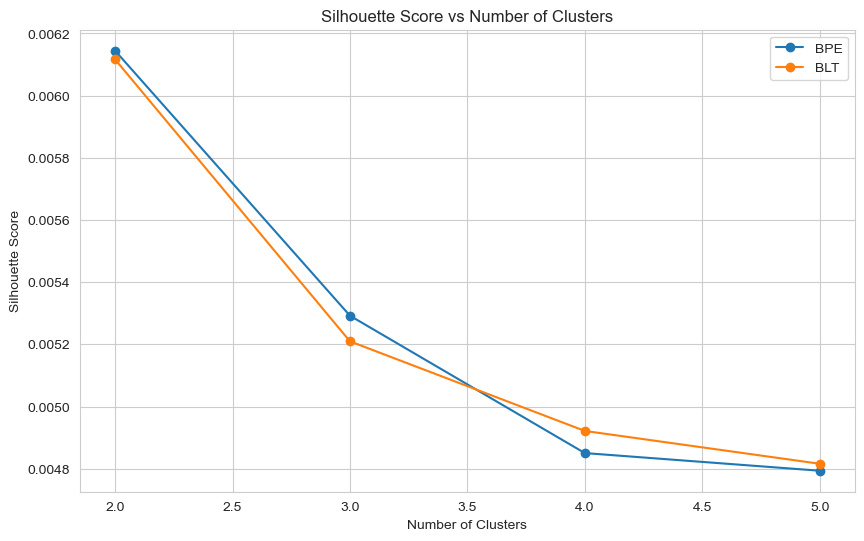

BPE Best Score: 0.0061 (n_clusters=2)
BLT Best Score: 0.0061 (n_clusters=2)


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

def calculate_silhouette_scores(vectors_dict, n_clusters_range=range(2, 6), random_state=42, plot=True):
    """
    Calculate silhouette scores for multiple embedding vectors across different numbers of clusters.

    Parameters:
    -----------
    vectors_dict : dict
        Dictionary of embedding vectors where key is the name and value is the numpy array of vectors
        e.g., {'BPE': bpe_vectors, 'BLT': blt_vectors}
    n_clusters_range : range or list, optional
        Range of number of clusters to try
    random_state : int, optional
        Random state for KMeans
    plot : bool, optional
        Whether to plot the results

    Returns:
    --------
    dict
        Dictionary containing:
        - 'scores': Dictionary of silhouette scores for each embedding type and cluster number
        - 'best_scores': Dictionary of best scores and their corresponding cluster numbers
    """
    results = {
        'scores': {name: [] for name in vectors_dict.keys()},
        'best_scores': {}
    }

    # Calculate scores for each number of clusters
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

        for name, vectors in vectors_dict.items():
            labels = kmeans.fit_predict(vectors)
            score = silhouette_score(vectors, labels)
            results['scores'][name].append(score)

    # Find best scores
    for name in vectors_dict.keys():
        scores = results['scores'][name]
        best_score = max(scores)
        best_n_clusters = n_clusters_range[scores.index(best_score)]
        results['best_scores'][name] = {
            'score': best_score,
            'n_clusters': best_n_clusters
        }

    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        for name, scores in results['scores'].items():
            plt.plot(list(n_clusters_range), scores, 'o-', label=name)

        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.legend()
        plt.grid(True)
        plt.show()

    return results

# Get embeddings from DuckDB
query = """
SELECT
    embedding_bpe::DOUBLE[] as bpe_embedding,
    embedding_blt::DOUBLE[] as blt_embedding
FROM embeddings
"""
results = con.execute(query).fetchdf()

# Convert to numpy arrays
bpe_vectors = np.stack(results['bpe_embedding'].values)
blt_vectors = np.stack(results['blt_embedding'].values)

# Create vectors dictionary
vectors_dict = {
    'BPE': bpe_vectors,
    'BLT': blt_vectors
}

# Calculate scores
results = calculate_silhouette_scores(vectors_dict)

# Print best scores
for name, result in results['best_scores'].items():
    print(f"{name} Best Score: {result['score']:.4f} (n_clusters={result['n_clusters']})")

Note: This isn't optimized

Result: there isn't a huge difference between BPE and BLT embeddings here.

Slightly better at high cluster scores. That can be relevant in some cases.

## Cosine Similarity distribution

For tasks related to NLP, Cosine Similarity is preferable as a metric over Euclidian distance.

In [4]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_similarities(con, embedding_types, batch_size=1000):
    """
    Calculate pairwise similarities for multiple embedding types from a DuckDB database.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        DuckDB connection
    embedding_types : list
        List of embedding type names to process
    batch_size : int, optional
        Size of batches for processing

    Returns:
    --------
    dict
        Dictionary with embedding types as keys and similarity arrays as values
    """
    # Get total row count
    count_query = "SELECT COUNT(*) as cnt FROM embeddings"
    total_rows = con.execute(count_query).fetchone()[0]

    base_query_template = """
    WITH numbered_rows AS (
        SELECT
            ROW_NUMBER() OVER () as row_id,
            embedding_{type}::DOUBLE[] as embedding
        FROM embeddings
        LIMIT {limit} OFFSET {offset}
    )
    SELECT
        a.row_id as id1,
        b.row_id as id2,
        (a.embedding <=> b.embedding) as cosine_similarity
    FROM numbered_rows a
    CROSS JOIN numbered_rows b
    WHERE a.row_id < b.row_id
    """

    similarities = {etype: [] for etype in embedding_types}

    with tqdm(total=total_rows, desc="Processing embeddings") as pbar:
        for offset in range(0, total_rows, batch_size):
            for etype in embedding_types:
                query = base_query_template.format(
                    type=etype,
                    limit=batch_size,
                    offset=offset
                )
                batch = con.execute(query).fetchnumpy()['cosine_similarity']
                similarities[etype].extend(batch)

            pbar.update(batch_size)

    return {k: np.array(v) for k, v in similarities.items()}

def calculate_distribution_stats(similarities):
    """
    Calculate statistical measures for a similarity distribution.

    Parameters:
    -----------
    similarities : np.array
        Array of similarity values

    Returns:
    --------
    dict
        Dictionary containing various statistical measures
    """
    kde = stats.gaussian_kde(similarities)
    x_eval = np.linspace(similarities.min(), similarities.max(), 100)
    kde_values = kde(x_eval)
    mode_idx = np.argmax(kde_values)
    mode_value = x_eval[mode_idx]

    return {
        'n_samples': len(similarities),
        'mean': np.mean(similarities),
        'median': np.median(similarities),
        'mode': mode_value,
        'std': np.std(similarities),
        'percentile_25': np.percentile(similarities, 25),
        'percentile_75': np.percentile(similarities, 75),
        'kde': kde,
        'x_eval': x_eval,
        'kde_values': kde_values
    }

def plot_similarity_distributions(similarities_dict, figsize=(20, 7)):
    """
    Plot similarity distributions with statistics.

    Parameters:
    -----------
    similarities_dict : dict
        Dictionary with embedding types as keys and similarity arrays as values
    figsize : tuple, optional
        Figure size for the plot

    Returns:
    --------
    tuple
        Figure and axes objects, and dictionary of statistics for each distribution
    """
    n_plots = len(similarities_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]

    stats_dict = {}

    for (etype, similarities), ax in zip(similarities_dict.items(), axes):
        stats = calculate_distribution_stats(similarities)
        stats_dict[etype] = stats

        # Plot distribution
        sns.kdeplot(data=similarities, fill=True, bw_adjust=0.5, ax=ax)
        sns.rugplot(data=similarities, color='red', alpha=0.2, ax=ax)

        # Add statistical lines
        ax.axvline(x=stats['mode'], color='red', linestyle='--',
                  alpha=0.5, label=f'Mode: {stats["mode"]:.3f}')
        ax.axvline(x=stats['mean'], color='green', linestyle='--',
                  alpha=0.5, label=f'Mean: {stats["mean"]:.3f}')
        ax.axvline(x=stats['median'], color='blue', linestyle='--',
                  alpha=0.5, label=f'Median: {stats["median"]:.3f}')

        ax.set_title(f'{etype} Embeddings Self-Similarity Distribution')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, axes, stats_dict

def print_distribution_stats(stats_dict):
    """
    Print statistical measures for all distributions.

    Parameters:
    -----------
    stats_dict : dict
        Dictionary containing statistics for each distribution
    """
    for etype, stats in stats_dict.items():
        print(f"\n{etype} Embeddings Distribution Statistics:")
        print(f"Number of samples: {stats['n_samples']}")
        print(f"Mean: {stats['mean']:.4f}")
        print(f"Median: {stats['median']:.4f}")
        print(f"Mode (KDE peak): {stats['mode']:.4f}")
        print(f"Standard deviation: {stats['std']:.4f}")
        print(f"25th percentile: {stats['percentile_25']:.4f}")
        print(f"75th percentile: {stats['percentile_75']:.4f}")

# Example usage:
def analyze_embedding_similarities(con, embedding_types=['bpe', 'blt'], batch_size=1000):
    """
    Complete analysis pipeline for embedding similarities.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        DuckDB connection
    embedding_types : list, optional
        List of embedding types to analyze
    batch_size : int, optional
        Batch size for processing

    Returns:
    --------
    tuple
        Similarities dictionary, figure, axes, and statistics dictionary
    """
    # Calculate similarities
    similarities_dict = calculate_similarities(con, embedding_types, batch_size)

    # Plot distributions and calculate statistics
    fig, axes, stats_dict = plot_similarity_distributions(similarities_dict)

    # Print statistics
    print_distribution_stats(stats_dict)

    return similarities_dict, fig, axes, stats_dict

# Usage example:
# similarities_dict, fig, axes, stats_dict = analyze_embedding_similarities(con)

Processing embeddings:   0%|          | 0/13455 [00:00<?, ?it/s]


bpe Embeddings Distribution Statistics:
Number of samples: 6596785
Mean: 0.9697
Median: 0.9697
Mode (KDE peak): 0.9680
Standard deviation: 0.0701
25th percentile: 0.9222
75th percentile: 1.0171

blt Embeddings Distribution Statistics:
Number of samples: 6596785
Mean: 0.9674
Median: 0.9674
Mode (KDE peak): 0.9719
Standard deviation: 0.0699
25th percentile: 0.9200
75th percentile: 1.0146

Additional analysis for bpe:
Interquartile range: 0.0949
Range: 0.7197

Additional analysis for blt:
Interquartile range: 0.0946
Range: 0.6839


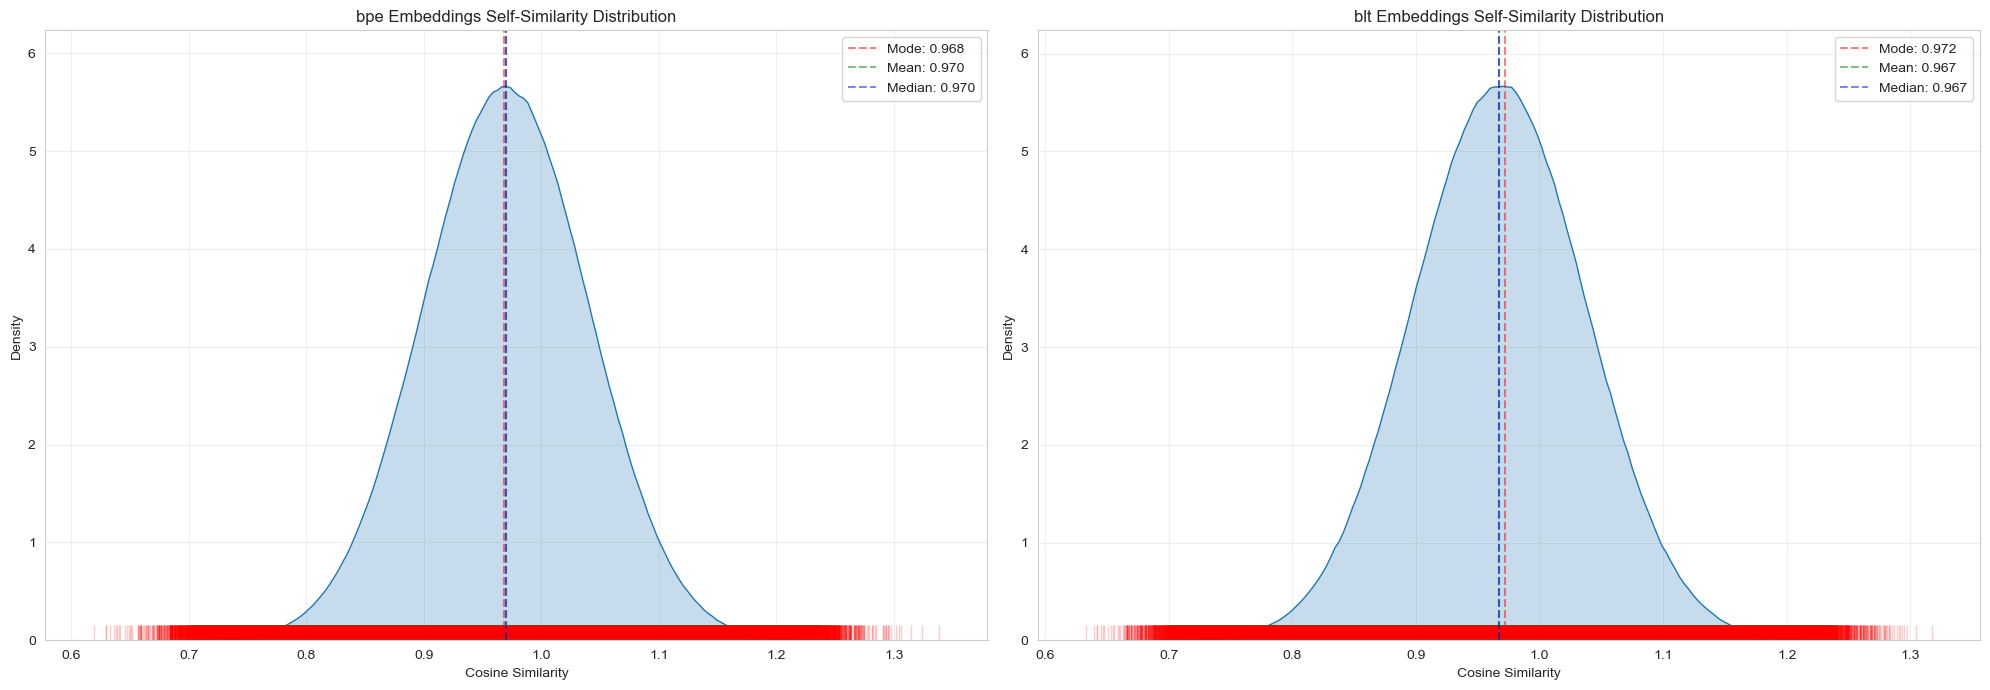

In [5]:
# Analyze embedding similarities with default parameters (BPE and BLT)
similarities_dict, fig, axes, stats_dict = analyze_embedding_similarities(
    con=con,
    embedding_types=['bpe', 'blt'],
    batch_size=1000
)

# The plot will be automatically displayed due to the function
# If you want to save the figure, you can do:
# fig.savefig('embedding_similarities.png', dpi=300, bbox_inches='tight')

# The statistics are already printed by the function, but you can access them directly:
# Access specific statistics for each embedding type
for etype, stats in stats_dict.items():
    print(f"\nAdditional analysis for {etype}:")
    print(f"Interquartile range: {stats['percentile_75'] - stats['percentile_25']:.4f}")
    print(f"Range: {similarities_dict[etype].max() - similarities_dict[etype].min():.4f}")

# You can also access the raw similarity values if needed:
bpe_similarities = similarities_dict['bpe']
blt_similarities = similarities_dict['blt']

We want a good distribution to be able to train classifiers here. BPE appears to slightly better, because the distribution range is wider. But this is microscopic, so we can't really tell.

## Clustering test

Can we cluster the embeddings? Has a semantic / meaningful structure been retained or do we see information loss?

Deep Learning suffers from the *Curse of Dimensionality*. Here we can use **UMAP** to visualize the Embeddings. If possible, the dataset shouldn't appear to be scattered (not be like rain in an Anime), but grouped as a cluster of distinguished feature points.

In [8]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import Dict, Tuple, List

def fetch_embeddings(con, embedding_types: List[str]) -> Dict[str, np.ndarray]:
    """
    Fetch embedding vectors from the database.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        Database connection
    embedding_types : list
        List of embedding types to fetch

    Returns:
    --------
    dict
        Dictionary with embedding types as keys and numpy arrays as values
    """
    vectors = {}
    for etype in embedding_types:
        query = f"SELECT embedding_{etype}::DOUBLE[] FROM embeddings"
        result = con.execute(query).fetchnumpy()
        vectors[etype] = np.array([vec for vec in result[f'CAST(embedding_{etype} AS DOUBLE[])']])
    return vectors

def preprocess_vectors(vectors_dict: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Standardize vectors using StandardScaler.

    Parameters:
    -----------
    vectors_dict : dict
        Dictionary of embedding vectors

    Returns:
    --------
    dict
        Dictionary of scaled vectors
    """
    scaler = StandardScaler()
    return {
        name: scaler.fit_transform(vectors)
        for name, vectors in vectors_dict.items()
    }

def create_umap_reducers(n_neighbors: int = 30,
                        min_dist: float = 0.1,
                        n_components: int = 2,
                        metric: str = 'cosine',
                        random_state: int = 42,
                        n_jobs: int = -1) -> Dict[str, umap.UMAP]:
    """
    Create UMAP reducers with specified configuration.

    Parameters:
    -----------
    n_neighbors : int
        Number of neighbors to consider
    min_dist : float
        Minimum distance between points
    n_components : int
        Number of dimensions to reduce to
    metric : str
        Distance metric to use
    random_state : int
        Random seed for reproducibility
    n_jobs : int
        Number of CPU cores to use

    Returns:
    --------
    dict
        Dictionary of UMAP reducers
    """
    umap_config = {
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'n_components': n_components,
        'metric': metric,
        'random_state': random_state,
        'n_jobs': n_jobs
    }
    return umap.UMAP(**umap_config)

def fit_transform_umap(vectors_dict: Dict[str, np.ndarray],
                      umap_reducer: umap.UMAP) -> Dict[str, np.ndarray]:
    """
    Apply UMAP dimension reduction to vectors.

    Parameters:
    -----------
    vectors_dict : dict
        Dictionary of preprocessed vectors
    umap_reducer : umap.UMAP
        Configured UMAP reducer

    Returns:
    --------
    dict
        Dictionary of reduced vectors
    """
    return {
        name: umap_reducer.fit_transform(vectors)
        for name, vectors in vectors_dict.items()
    }

def plot_umap_results(umap_results: Dict[str, np.ndarray],
                     figsize: Tuple[int, int] = (20, 8)) -> Tuple[plt.Figure, np.ndarray]:
    """
    Create UMAP visualization plots.

    Parameters:
    -----------
    umap_results : dict
        Dictionary of UMAP results
    figsize : tuple
        Figure size

    Returns:
    --------
    tuple
        Figure and axes objects
    """
    fig, axes = plt.subplots(1, len(umap_results), figsize=figsize)
    if len(umap_results) == 1:
        axes = [axes]

    def plot_single_umap(ax, data, title):
        scatter = ax.scatter(
            data[:, 0],
            data[:, 1],
            s=3,
            alpha=0.6,
            c=data[:, 0],
            cmap='viridis',
        )
        ax.set_title(title, fontsize=14, pad=20)
        ax.set_xlabel('UMAP component 1', fontsize=12)
        ax.set_ylabel('UMAP component 2', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.3)
        fig.colorbar(scatter, ax=ax, label='Component 1 value')

    for (name, data), ax in zip(umap_results.items(), axes):
        plot_single_umap(ax, data, f'UMAP Visualization of {name.upper()} Vectors\n(cosine metric, normalized)')

    plt.tight_layout()
    return fig, axes

def print_embedding_statistics(vectors_dict: Dict[str, np.ndarray]):
    """
    Print statistics about embedding vectors.

    Parameters:
    -----------
    vectors_dict : dict
        Dictionary of embedding vectors
    """
    for name, vectors in vectors_dict.items():
        print(f"\n{name.upper()} Embeddings Statistics:")
        norms = np.linalg.norm(vectors, axis=1)
        print(f"Mean vector norm: {norms.mean():.4f}")
        print(f"Std vector norm: {norms.std():.4f}")
        print(f"Min vector norm: {norms.min():.4f}")
        print(f"Max vector norm: {norms.max():.4f}")

def analyze_embeddings_umap(con,
                          embedding_types=['bpe', 'blt'],
                          n_neighbors=30,
                          min_dist=0.1,
                          random_state=42) -> Tuple[Dict, plt.Figure, np.ndarray]:
    """
    Complete pipeline for UMAP analysis of embeddings.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        Database connection
    embedding_types : list
        List of embedding types to analyze
    n_neighbors : int
        Number of neighbors for UMAP
    min_dist : float
        Minimum distance between points
    random_state : int
        Random seed

    Returns:
    --------
    tuple
        Original vectors, UMAP results, figure, and axes
    """
    # Fetch vectors
    vectors_dict = fetch_embeddings(con, embedding_types)

    # Preprocess vectors
    vectors_scaled = preprocess_vectors(vectors_dict)

    # Create and apply UMAP
    umap_reducer = create_umap_reducers(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )

    # Fit and transform
    umap_results = fit_transform_umap(vectors_scaled, umap_reducer)

    # Create visualization
    fig, axes = plot_umap_results(umap_results)

    # Print statistics
    print_embedding_statistics(vectors_dict)

    return vectors_dict, umap_results, fig, axes

c:\Users\mariu\anaconda3\envs\log2ml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



BPE Embeddings Statistics:
Mean vector norm: 18.0688
Std vector norm: 0.8002
Min vector norm: 14.9013
Max vector norm: 24.4793

BLT Embeddings Statistics:
Mean vector norm: 18.3255
Std vector norm: 0.9138
Min vector norm: 15.4433
Max vector norm: 45.8856


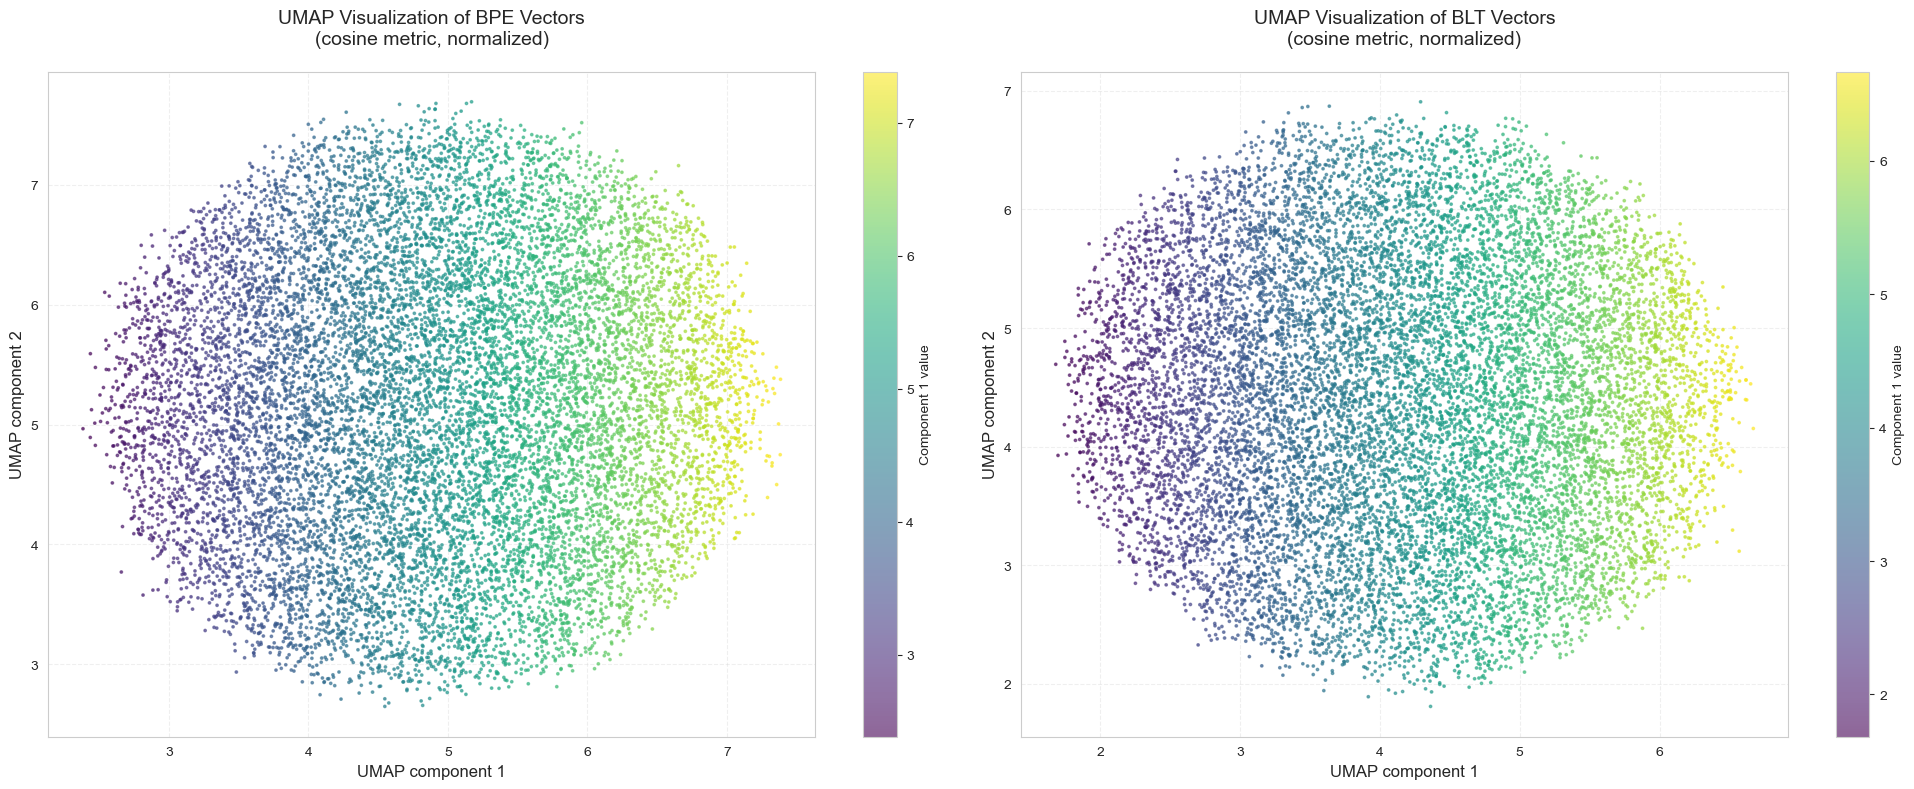

In [9]:
# Run the complete analysis
vectors_dict, umap_results, fig, axes = analyze_embeddings_umap(
    con=con,
    embedding_types=['bpe', 'blt'],
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

# Show the plot
plt.show()

# Optional: save the figure
# fig.savefig('umap_visualization.png', dpi=300, bbox_inches='tight')

The smooth, continuous distribution in UMAP (rather than distinct clusters) combined with the very even distribution of variance in the PCA (see below) suggests that:

- The Embeddings are capturing continuous semantic relationships
- Each dimension contributes meaningfully to the overall representation

There's no "wasted" or redundant dimensions

This is actually desirable for log message embeddings because:

- Log messages exist on a continuous spectrum of meaning
- Similar logs should have similar but not identical embeddings
- The gradual color transition in UMAP shows smooth semantic transitions

If we had seen distinct clusters, it might have indicated:

- Over-simplification of the semantic space
- The model learning only categorical features
- Potential loss of nuanced differences between logs


The similarity between BPE and BLT visualizations also validates that:

- Both tokenization approaches are capturing similar semantic structures
- The choice of tokenization method isn't introducing significant bias
- The embedding space is being used similarly in both cases

## Principal Component Analysis

The Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving the most important information.

We use this as a further assessment of the Embeddings.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Any

def fetch_embeddings(con, embedding_types: List[str]) -> Dict[str, np.ndarray]:
    """
    Fetch embedding vectors from the database.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        Database connection
    embedding_types : list
        List of embedding types to fetch

    Returns:
    --------
    dict
        Dictionary with embedding types as keys and numpy arrays as values
    """
    vectors = {}
    for etype in embedding_types:
        query = f"SELECT embedding_{etype}::DOUBLE[] FROM embeddings"
        result = con.execute(query).fetchnumpy()
        vectors[etype] = np.array([vec for vec in result[f'CAST(embedding_{etype} AS DOUBLE[])']])
    return vectors

def perform_pca_analysis(vectors_dict: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """
    Perform PCA analysis on vectors.

    Parameters:
    -----------
    vectors_dict : dict
        Dictionary of embedding vectors

    Returns:
    --------
    dict
        Dictionary containing PCA results
    """
    results = {}
    scaler = StandardScaler()

    for name, vectors in vectors_dict.items():
        # Standardize
        vectors_scaled = scaler.fit_transform(vectors)

        # Fit PCA
        pca = PCA()
        pca.fit(vectors_scaled)

        # Store results
        results[name] = {
            'pca': pca,
            'cum_var': np.cumsum(pca.explained_variance_ratio_),
            'n_dimensions': vectors.shape[1]
        }

    return results

def calculate_components_needed(pca_results: Dict[str, Dict],
                             thresholds: List[float]) -> Dict[str, List[int]]:
    """
    Calculate number of components needed for various variance thresholds.

    Parameters:
    -----------
    pca_results : dict
        Dictionary of PCA results
    thresholds : list
        List of variance thresholds

    Returns:
    --------
    dict
        Dictionary of components needed for each threshold
    """
    components_needed = {}

    for name, results in pca_results.items():
        cum_var = results['cum_var']
        components_needed[name] = [np.argmax(cum_var >= t) + 1 for t in thresholds]

    return components_needed

def plot_explained_variance(pca_results: Dict[str, Dict],
                          thresholds: List[float],
                          figsize: Tuple[int, int] = (12, 6)) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot cumulative explained variance.

    Parameters:
    -----------
    pca_results : dict
        Dictionary of PCA results
    thresholds : list
        List of variance thresholds
    figsize : tuple
        Figure size

    Returns:
    --------
    tuple
        Figure and axes objects
    """
    fig, ax = plt.subplots(figsize=figsize)

    colors = {'bpe': '#2ecc71', 'blt': '#e74c3c'}

    for name, results in pca_results.items():
        ax.plot(results['cum_var'], label=name.upper(), color=colors.get(name.lower()))

    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance Ratio')
    ax.set_title('PCA Cumulative Explained Variance')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

    # Add threshold lines
    for threshold in thresholds:
        ax.axhline(y=threshold, color='gray', linestyle='--', alpha=0.3)
        ax.text(len(next(iter(pca_results.values()))['cum_var']) * 0.02,
                threshold, f'{threshold*100}%',
                verticalalignment='bottom')

    plt.tight_layout()
    return fig, ax

def print_pca_analysis(pca_results: Dict[str, Dict],
                      components_needed: Dict[str, List[int]],
                      thresholds: List[float]):
    """
    Print PCA analysis results.

    Parameters:
    -----------
    pca_results : dict
        Dictionary of PCA results
    components_needed : dict
        Dictionary of components needed for each threshold
    thresholds : list
        List of variance thresholds
    """
    # Print components needed
    print("\nNumber of components needed for variance thresholds:")
    print(f"{'Threshold':<10} {'BPE':<10} {'BLT':<10}")
    print("-" * 30)
    for threshold, bpe_n, blt_n in zip(thresholds,
                                      components_needed['bpe'],
                                      components_needed['blt']):
        print(f"{threshold*100:>3.0f}%{' '*6} {bpe_n:<10} {blt_n:<10}")

    # Print top 10 components
    print("\nTop 10 components' explained variance:")
    print(f"{'Component':<10} {'BPE':<10} {'BLT':<10}")
    print("-" * 30)
    for i in range(10):
        bpe_var = pca_results['bpe']['pca'].explained_variance_ratio_[i]
        blt_var = pca_results['blt']['pca'].explained_variance_ratio_[i]
        print(f"{i+1:<10} {bpe_var:.4f}    {blt_var:.4f}")

    # Print dimensions
    print(f"\nTotal dimensions:")
    for name, results in pca_results.items():
        print(f"{name.upper()}: {results['n_dimensions']}")

def analyze_embeddings_pca(con,
                         embedding_types=['bpe', 'blt'],
                         thresholds=[0.8, 0.9, 0.95, 0.99]) -> Tuple[Dict, Dict, plt.Figure, plt.Axes]:
    """
    Complete pipeline for PCA analysis of embeddings.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        Database connection
    embedding_types : list
        List of embedding types to analyze
    thresholds : list
        List of variance thresholds

    Returns:
    --------
    tuple
        PCA results, components needed, figure, and axes
    """
    # Fetch vectors
    vectors_dict = fetch_embeddings(con, embedding_types)

    # Perform PCA analysis
    pca_results = perform_pca_analysis(vectors_dict)

    # Calculate components needed
    components_needed = calculate_components_needed(pca_results, thresholds)

    # Create visualization
    fig, ax = plot_explained_variance(pca_results, thresholds)

    # Print analysis
    print_pca_analysis(pca_results, components_needed, thresholds)

    return pca_results, components_needed, fig, ax


Number of components needed for variance thresholds:
Threshold  BPE        BLT       
------------------------------
 80%       155        156       
 90%       195        197       
 95%       222        222       
 99%       248        248       

Top 10 components' explained variance:
Component  BPE        BLT       
------------------------------
1          0.0098    0.0096
2          0.0096    0.0095
3          0.0093    0.0094
4          0.0091    0.0090
5          0.0091    0.0089
6          0.0089    0.0088
7          0.0088    0.0087
8          0.0087    0.0087
9          0.0086    0.0085
10         0.0085    0.0083

Total dimensions:
BPE: 256
BLT: 256


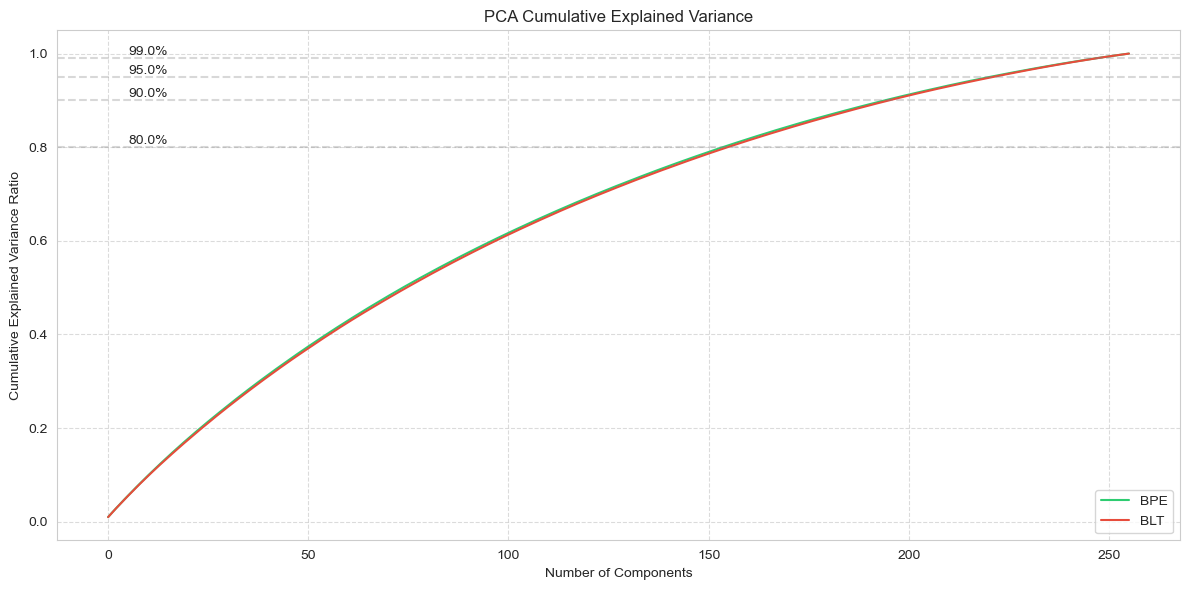

In [11]:
# Run the complete analysis
pca_results, components_needed, fig, ax = analyze_embeddings_pca(
    con=con,
    embedding_types=['bpe', 'blt'],
    thresholds=[0.8, 0.9, 0.95, 0.99]
)

# Show the plot
plt.show()

# Optional: save the figure
# fig.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')

### Information Distribution:

Both BPE and BLT embeddings use their dimensions very similarly (almost identical curves)

The variance is very evenly distributed across components (each of top 10 components explains ~0.9% of variance)
We need about 155-156 dimensions to capture 80% of the variance.


### Dimensionality Assessment:

The fact that you need many dimensions (222 for 95% variance) suggests that our Embeddings are efficiently using the space

There's no clear "elbow" in the curve, indicating that the information is distributed quite uniformly
This is actually a good sign for embeddings, as it suggests they're capturing different aspects of the data.


### Why This is Good:

- If we had very few components explaining most variance, it would suggest potential underfitting
- The uniform distribution suggests your model is learning diverse features
- The similarity between BPE and BLT suggests both approaches are equally effective at capturing information

## Summary

**The UMAP visualization and the PCA analysis actually tell a consistent story** 

Both options are totally valid.

The choice between BPE and BLT is a matter of preference and the choice depends on the specific use case. Especially when it comes to logs, which isn't super valueable data per se.

## Comparison of BPE and BLT Embeddings Cosine Similarity Distribution with Standard Scaling or with Quantile Transformation 

The following code uses DuckDB to retrieve two Embeddings from the DuckDB database, transfers them to the GPU, and then compares the Cosine Similarity distribution between the original Embeddings, the Embeddings after standard scaling, and the Embeddings after quantile transformation.

This uses *cupy* which is like *numpy* but for GPU. The plotting still uses the CPU, so there is a bottleneck.

Still, GPU version is about 10x faster than the CPU version. :)

In [12]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict, Any

class GPUSimilarityAnalyzer:
    def __init__(self, device_id: int = 0):
        """
        Initialize GPU analyzer.

        Parameters:
        -----------
        device_id : int
            CUDA device ID
        """
        self.init_gpu(device_id)

    @staticmethod
    def init_gpu(device_id: int):
        """Initialize GPU device."""
        try:
            cp.cuda.runtime.setDevice(device_id)
            print("GPU initialized successfully")
        except Exception as e:
            raise RuntimeError(f"GPU initialization failed: {str(e)}")

    @staticmethod
    def kde_gpu(data_gpu: cp.ndarray, bw_adjust: float = 0.5,
                grid_points: int = 200) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute KDE using GPU.

        Parameters:
        -----------
        data_gpu : cp.ndarray
            Input data on GPU
        bw_adjust : float
            Bandwidth adjustment factor
        grid_points : int
            Number of points in evaluation grid

        Returns:
        --------
        tuple
            Grid points and KDE values
        """
        data_min = float(cp.min(data_gpu))
        data_max = float(cp.max(data_gpu))
        x_grid = cp.linspace(data_min, data_max, grid_points)

        n = len(data_gpu)
        bandwidth = bw_adjust * cp.std(data_gpu) * (n ** (-1/5))

        kde_values = cp.zeros_like(x_grid)

        for i in range(0, len(data_gpu), 1000):
            batch = data_gpu[i:i+1000]
            diff = x_grid[:, None] - batch[None, :]
            kernel = cp.exp(-0.5 * (diff / bandwidth) ** 2)
            kde_values += cp.sum(kernel, axis=1)

        kde_values = kde_values / (n * bandwidth * cp.sqrt(2 * cp.pi))

        return cp.asnumpy(x_grid), cp.asnumpy(kde_values)

    def get_cosine_similarities_gpu_batched(self, vectors_gpu: cp.ndarray,
                                          batch_size: int = 1000) -> cp.ndarray:
        """
        Calculate pairwise cosine similarities using GPU in batches.

        Parameters:
        -----------
        vectors_gpu : cp.ndarray
            Input vectors on GPU
        batch_size : int
            Batch size for processing

        Returns:
        --------
        cp.ndarray
            Similarity matrix
        """
        n_vectors = len(vectors_gpu)
        norms = cp.linalg.norm(vectors_gpu, axis=1)
        normalized = vectors_gpu / norms[:, cp.newaxis]

        similarities_gpu = cp.empty((n_vectors * (n_vectors - 1)) // 2, dtype=cp.float32)
        current_idx = 0

        for i in tqdm(range(0, n_vectors, batch_size), desc="Computing similarities"):
            end_idx = min(i + batch_size, n_vectors)
            batch_sims = cp.dot(normalized[i:end_idx], normalized.T)

            for j in range(i, end_idx):
                row_sims = batch_sims[j - i, (j + 1):]
                if len(row_sims) > 0:
                    chunk_size = len(row_sims)
                    similarities_gpu[current_idx:current_idx + chunk_size] = row_sims
                    current_idx += chunk_size

            batch_sims = None
            cp.get_default_memory_pool().free_all_blocks()

        return similarities_gpu[:current_idx]

    def get_transformed_similarities(self, con, embedding_type: str) -> Tuple[cp.ndarray, cp.ndarray, cp.ndarray]:
        """
        Get similarities for original and transformed vectors.

        Parameters:
        -----------
        con : duckdb.DuckDBPyConnection
            Database connection
        embedding_type : str
            Type of embedding to process

        Returns:
        --------
        tuple
            Original, standardized, and quantile-transformed similarities
        """
        query = f"SELECT embedding_{embedding_type}::DOUBLE[] FROM embeddings"
        result = con.execute(query).fetchnumpy()
        vectors_cpu = np.array([vec for vec in result[f'CAST(embedding_{embedding_type} AS DOUBLE[])']])
        print(f"Processing {len(vectors_cpu)} vectors")

        vectors_gpu = cp.array(vectors_cpu)
        sims_original = self.get_cosine_similarities_gpu_batched(vectors_gpu)

        scaler = StandardScaler()
        vectors_scaled_gpu = cp.array(scaler.fit_transform(vectors_cpu))
        sims_scaled = self.get_cosine_similarities_gpu_batched(vectors_scaled_gpu)

        quantile = QuantileTransformer(output_distribution='normal')
        vectors_quantile_gpu = cp.array(quantile.fit_transform(vectors_cpu))
        sims_quantile = self.get_cosine_similarities_gpu_batched(vectors_quantile_gpu)

        vectors_gpu = vectors_scaled_gpu = vectors_quantile_gpu = None
        cp.get_default_memory_pool().free_all_blocks()

        return sims_original, sims_scaled, sims_quantile

    @staticmethod
    def plot_similarity_distributions(bpe_sims: Tuple[cp.ndarray, ...],
                                   blt_sims: Tuple[cp.ndarray, ...],
                                   kde_func: callable,
                                   figsize: Tuple[int, int] = (15, 8)) -> Tuple[plt.Figure, plt.Axes]:
        """
        Plot similarity distributions.

        Parameters:
        -----------
        bpe_sims : tuple
            BPE similarities (original, standardized, quantile)
        blt_sims : tuple
            BLT similarities (original, standardized, quantile)
        kde_func : callable
            KDE function to use
        figsize : tuple
            Figure size

        Returns:
        --------
        tuple
            Figure and axes objects
        """
        fig, ax = plt.subplots(figsize=figsize)
        colors = ['#2ecc71', '#3498db', '#e74c3c']
        labels = ['Original', 'Standardized', 'Quantile']

        for i, (bpe_sim, blt_sim) in enumerate(zip(bpe_sims, blt_sims)):
            x_bpe, y_bpe = kde_func(bpe_sim, bw_adjust=0.5)
            x_blt, y_blt = kde_func(blt_sim, bw_adjust=0.5)

            ax.plot(x_bpe, y_bpe, color=colors[i], linestyle='-',
                   label=f'BPE - {labels[i]}', linewidth=2)
            ax.plot(x_blt, y_blt, color=colors[i], linestyle='--',
                   label=f'BLT - {labels[i]}', linewidth=2)

        ax.set_title('Cosine Similarity Distributions (Full GPU)', fontsize=16)
        ax.set_xlabel('Cosine Similarity', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

        return fig, ax

    @staticmethod
    def print_statistics(bpe_sims: Tuple[cp.ndarray, ...],
                        blt_sims: Tuple[cp.ndarray, ...]):
        """Print statistics for all similarity distributions."""
        labels = ['Original', 'Standardized', 'Quantile']

        for i, label in enumerate(labels):
            for embed_type, sims in [('BPE', bpe_sims[i]), ('BLT', blt_sims[i])]:
                print(f"\n{embed_type} - {label} Statistics:")
                print(f"Mean: {float(cp.mean(sims)):.4f}")
                print(f"Std: {float(cp.std(sims)):.4f}")
                print(f"Min: {float(cp.min(sims)):.4f}")
                print(f"Max: {float(cp.max(sims)):.4f}")
                print(f"Total pairs: {len(sims)}")

def analyze_embeddings_gpu(con, device_id: int = 0) -> Dict[str, Any]:
    """
    Complete pipeline for GPU-accelerated embedding analysis.

    Parameters:
    -----------
    con : duckdb.DuckDBPyConnection
        Database connection
    device_id : int
        CUDA device ID

    Returns:
    --------
    dict
        Analysis results
    """
    try:
        analyzer = GPUSimilarityAnalyzer(device_id)

        # Get similarities for both embedding types
        print("Calculating similarities on GPU...")
        bpe_sims = analyzer.get_transformed_similarities(con, 'bpe')
        blt_sims = analyzer.get_transformed_similarities(con, 'blt')

        # Plot distributions
        print("Plotting distributions...")
        fig, ax = analyzer.plot_similarity_distributions(bpe_sims, blt_sims, analyzer.kde_gpu)

        # Print statistics
        print("\nCalculating statistics...")
        analyzer.print_statistics(bpe_sims, blt_sims)

        return {
            'bpe_similarities': bpe_sims,
            'blt_similarities': blt_sims,
            'figure': fig,
            'axes': ax
        }

    except ImportError:
        print("CuPy not installed. Please install it with:")
    except cp.cuda.runtime.CUDARuntimeError:
        print("No GPU available. Falling back to CPU version...")

GPU initialized successfully
Calculating similarities on GPU...
Processing 13455 vectors


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing 13455 vectors


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Plotting distributions...

Calculating statistics...

BPE - Original Statistics:
Mean: 0.0303
Std: 0.0701
Min: -0.3482
Max: 0.4115
Total pairs: 90511785

BLT - Original Statistics:
Mean: 0.0327
Std: 0.0699
Min: -0.3457
Max: 0.4235
Total pairs: 90511785

BPE - Standardized Statistics:
Mean: -0.0001
Std: 0.0704
Min: -0.3657
Max: 0.3912
Total pairs: 90511785

BLT - Standardized Statistics:
Mean: -0.0001
Std: 0.0702
Min: -0.3729
Max: 0.3898
Total pairs: 90511785

BPE - Quantile Statistics:
Mean: -0.0000
Std: 0.0704
Min: -0.3663
Max: 0.3912
Total pairs: 90511785

BLT - Quantile Statistics:
Mean: -0.0001
Std: 0.0701
Min: -0.3728
Max: 0.3926
Total pairs: 90511785


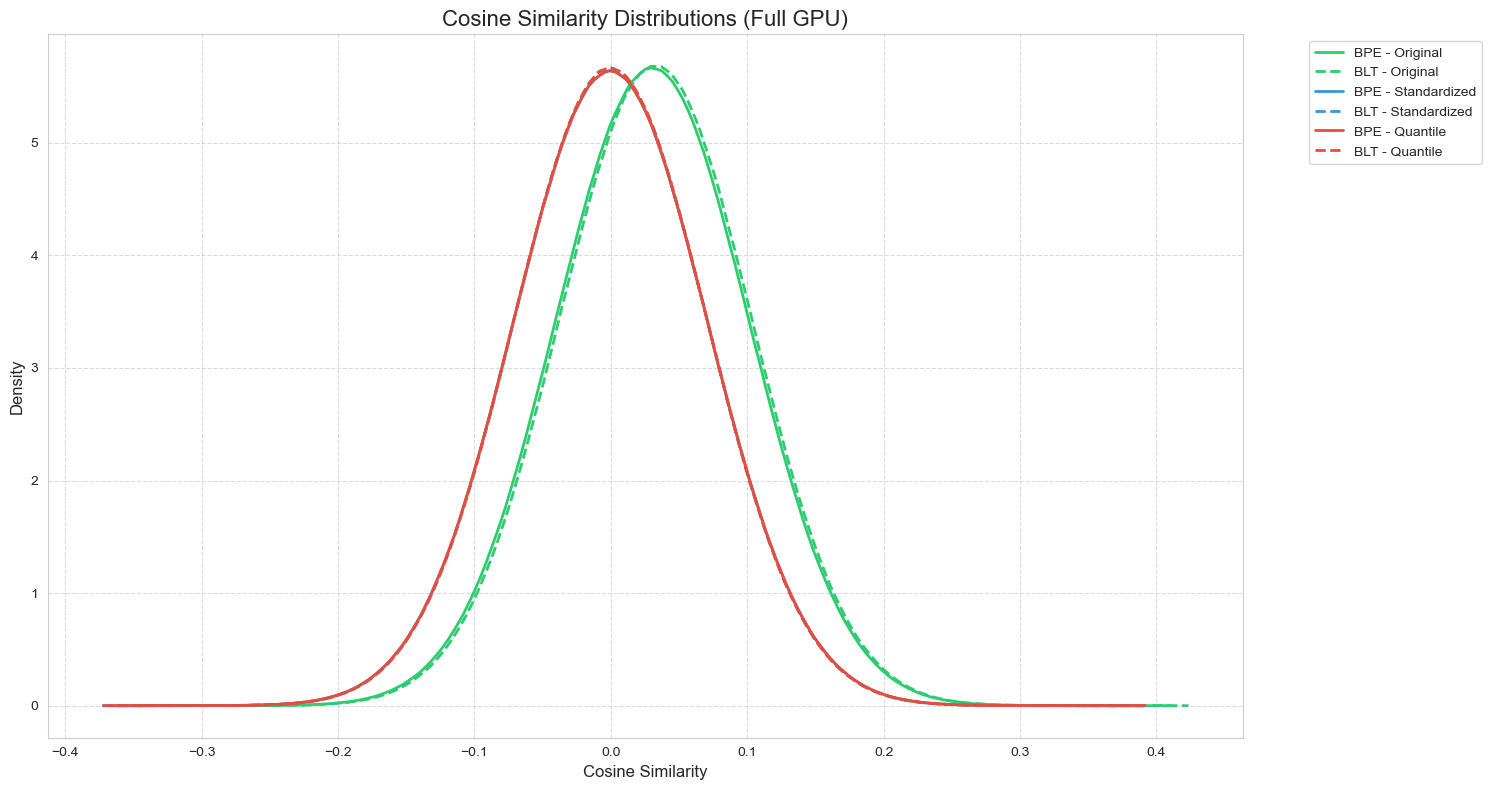

In [13]:
# Run the complete analysis
results = analyze_embeddings_gpu(con)

# Show the plot
plt.show()

# Optional: save the figure
# results['figure'].savefig('similarity_distributions.png', dpi=300, bbox_inches='tight')

#### BLT (dashed lines) shows:

- Slightly more consistent distribution across transformations
- Marginally better spread in the positive similarity region
- More stable behavior across different preprocessing methods

#### BPE (solid lines) shows:

- Very similar overall pattern
- Slightly more variable behavior across transformations
- Marginally narrower spread in some regions

BLT remains a little more consistent across various preprocessing methods. There are scale-sensitive and quantile-sensitive patterns, but in general, BLT is more consistent. It depends on the model architecture and the data distribution, but in general, BLT is more consistent.

## Using high-dimensional Linformer embeddings

It's all about information density.

In [1]:
import torch
from linformer import Linformer

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seq_len = 8192*4

# Create Linformer models with correct parameters
def create_linformer(max_seq_len, dim, seq_len=seq_len):
    model = Linformer(
        dim=dim,                    # Embedding dimension
        seq_len=seq_len,             # Maximum sequence length
        depth=6,                    # Number of transformer layers
        k=128,                      # Projected sequence length
        heads=8,                    # Number of attention heads
        dropout=0.1                 # Dropout probability 10%
    )
    return model.to(device)  # Move model to GPU if available

# Create models for both tokenization methods
embedding_dim = embedding_dim = int(64 * round(6 * (8192*4)**0.5 / 64)) # Embedding dimension for both models
print("Eebedding dim: %d" % embedding_dim )

try:
    linformer_bpe = create_linformer(max_seq_len=2024, dim=embedding_dim)
    linformer_blt = create_linformer(max_seq_len=2048, dim=embedding_dim)
    print("Linformer models created successfully!")

    # Function to process tokens and create embeddings
    def create_embeddings(tokens, model):
        # Create embedding layer and move to device
        embedding_layer = torch.nn.Embedding(
            num_embeddings=max(tokens) + 1,
            embedding_dim=embedding_dim
        ).to(device)

        # Convert tokens to tensor, add batch dimension, and move to device
        x = torch.tensor(tokens).unsqueeze(0).to(device)

        # Create embeddings
        x = embedding_layer(x)

        # Pass through Linformer
        with torch.no_grad():
            embeddings = model(x)

        return embeddings.squeeze(0)  # Return PyTorch tensor

    # Example usage
    test_text = "Hello, this is a test."

    # Get tokens
    bpe_tokens = bpe_tokenizer.encode(test_text)
    blt_tokens = blt_tokenizer.encode(test_text)

    print("\nToken lengths:")
    print(f"BPE tokens: {len(bpe_tokens)}")
    print(f"BLT tokens: {len(blt_tokens)}")

    # Create embeddings
    bpe_embeddings = create_embeddings(bpe_tokens, linformer_bpe)
    blt_embeddings = create_embeddings(blt_tokens, linformer_blt)

    print(f"\nEmbedding shapes:")
    print(f"BPE embedding shape: {tuple(bpe_embeddings.shape)}")
    print(f"BLT embedding shape: {tuple(blt_embeddings.shape)}")

    # Print a few values from the embeddings (move to CPU for display)
    print("\nFirst few values of embeddings:")
    print("BPE:", bpe_embeddings.cpu()[0, :5].tolist())  # First token, first 5 dimensions
    print("BLT:", blt_embeddings.cpu()[0, :5].tolist())  # First token, first 5 dimensions

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print(f"Error type: {type(e).__name__}")

Using device: cuda


NameError: name 'Path' is not defined

In [1]:
from pathlib import Path

def get_json_file_path():
    # Define the file path
    json_path = Path(r"C:\Users\mariu\source\datasets\log2ml\lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_clean.json")

    # Check if the file exists
    if json_path.exists():
        return json_path
    else:
        raise FileNotFoundError(f"The JSON file does not exist at: {json_path}")

In [2]:
json_path = ""
try:
    json_file_path = get_json_file_path()
    print(f"JSON file found at: {json_file_path}")
except FileNotFoundError as e:
    print(e)

JSON file found at: C:\Users\mariu\source\datasets\log2ml\lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_clean.json


In [ ]:
import torch
import pandas as pd
import json
import duckdb
from tqdm.notebook import tqdm
import gc

try:
    # Initialize DuckDB connection
    con = duckdb.connect('embeddings_1k.duckdb')

    # Create tables with vector columns
    con.execute("""
        CREATE TABLE IF NOT EXISTS embeddings (
            embedding_bpe DOUBLE[],  -- Vector type for BPE embeddings
            embedding_blt DOUBLE[],  -- Vector type for BLT embeddings
            original_text TEXT
        )
    """)

    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Process in smaller chunks
    chunk_size = 400

    for i in tqdm(range(0, len(data), chunk_size), desc="Processing chunks", leave=False):
        chunk = data[i:min(i+chunk_size, len(data))]

        # Initialize lists for current chunk
        chunk_data = []

        # Process each entry in the chunk
        for entry in chunk:
            text = json.dumps(entry)

            # Get tokens
            bpe_tokens = bpe_tokenizer.encode(text)
            blt_tokens = blt_tokenizer.encode(text)

            # Create embeddings and immediately move to CPU
            bpe_emb = create_embeddings(bpe_tokens, linformer_bpe).cpu()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            blt_emb = create_embeddings(blt_tokens, linformer_blt).cpu()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Convert tensors to lists directly
            chunk_data.append({
                'embedding_bpe': bpe_emb[0].detach().tolist(),
                'embedding_blt': blt_emb[0].detach().tolist(),
                'original_text': text
            })

        # Convert chunk to DataFrame
        df_chunk = pd.DataFrame(chunk_data)

        # Insert into DuckDB
        con.execute("INSERT INTO embeddings SELECT * FROM df_chunk")

        # Clear chunk data
        del chunk_data, df_chunk
        gc.collect()

    # Get final count
    count = con.execute("SELECT COUNT(*) FROM embeddings").fetchone()[0]

    print(f"\nProcessed {count} entries")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    print("\nFull traceback:")
    print(traceback.format_exc())

finally:
    # Cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    try:
        con.close()
    except:
        pass

Processing chunks:   0%|          | 0/34 [00:00<?, ?it/s]